In [6]:
# Import packages
from transformers import AutoModel, AutoTokenizer, AutoModelForCausalLM, AutoModelForMaskedLM
from peft import PeftModel, PeftConfig
from autoamp.evolveFinetune import *
import torch
from tqdm import tqdm
import math
from Bio import SeqIO 
import json
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from transformers import PreTrainedTokenizer

# Example inputs
base_model_name = "hugohrban/progen2-small" 
tokenizer = AutoTokenizer.from_pretrained(base_model_name, trust_remote_code=True)
adapter_checkpoint = "/home/sdowell/scratch/Thesis/ADP1/runs/progen2_dgoa_finetune_1/checkpoint-3000"

# Load models
model_pretrained = AutoModelForCausalLM.from_pretrained(base_model_name, trust_remote_code=True)
model_with_adapter = AutoModelForCausalLM.from_pretrained(base_model_name, trust_remote_code=True)
model_finetuned = PeftModel.from_pretrained(model_with_adapter, adapter_checkpoint)

# List of mutations provided as strings
mutations = ['F33I','D58N','A75V','Q72H','V85A','V154F','Y180F']

DgoA_seq= ("MQWQTKLPLIAILRGITPDEALAHVGAVIDAGFDAVEIPLNSPQWEQSIPAIVDAYGDKA"
"LIGAGTVLKPEQVDALARMGCQLIVTPNIHSEVIRRAVGYGMTVCPGCATATEAFTALEA"
"GAQALKIFPSSAFGPQYIKALKAVLPSDIAVFAVGGVTPENLAQWIDAGCAGAGLGSDLY"
"RAGQSVERTAQQAAAFVKAYREAVQ")

# Function to parse a mutation string, e.g. "F33I"
def parse_mutation(mutation_str):
    wt = mutation_str[0]  # wild-type residue
    mutant = mutation_str[-1]  # mutant residue
    pos = int(mutation_str[1:-1])  # position as provided (assumed 1-indexed)
    return wt, pos, mutant

def compute_mutation_llr_autoregressive(model, tokenizer, sequence, mutation, device):
    """
    Computes the log-likelihood ratio (LLR) for a mutation at a specified position
    using an autoregressive model. The probability of the token is computed conditioned 
    on the preceding tokens only.

    Args:
       model: Causal language model.
       tokenizer: Corresponding tokenizer.
       sequence: Protein sequence string.
       mutation: Mutation string (e.g. "F33I").
       device: torch.device instance.
       
    Returns:
       A tuple: (llr, log_prob_wildtype, log_prob_mutant)
    """
    import math
    import torch

    # Parse mutation details.
    wt, pos, mutant = mutation[0], int(mutation[1:-1]), mutation[-1]
    seq_index = pos - 1  # convert to 0-index

    # Verify wild type token.
    if sequence[seq_index] != wt:
        print(f"Warning: expected wild-type '{wt}' at position {pos}, but found '{sequence[seq_index]}'.")

    # The prefix is everything before the mutation position.
    prefix = sequence[:seq_index]
    encoded = tokenizer(prefix, return_tensors="pt")
    input_ids = encoded.input_ids.to(device)
    
    # Forward pass: get logits for the next token (the prediction for position 'seq_index').
    model.to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids)
        # For a causal LM, the logits corresponding to the next token is at the last position.
        # Shape: [batch, sequence_length, vocab_size]
        next_logits = outputs.logits[0, -1, :]
        # Compute probabilities.
        probs = torch.nn.functional.softmax(next_logits, dim=-1)

    # Convert wild-type and mutant residues to their token IDs.
    wt_token_id = tokenizer.convert_tokens_to_ids(wt)
    mutant_token_id = tokenizer.convert_tokens_to_ids(mutant)
    
    # Add a small epsilon to avoid log(0)
    eps = 1e-10
    prob_wt = probs[wt_token_id].item()
    prob_mutant = probs[mutant_token_id].item()
    log_prob_wt = math.log(prob_wt + eps)
    log_prob_mutant = math.log(prob_mutant + eps)
    
    # Compute the LLR.
    llr = log_prob_mutant - log_prob_wt
    return llr, log_prob_wt, log_prob_mutant

# Example usage:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Compute LLR for the pretrained model.
llr_pre, log_wt_pre, log_mut_pre = compute_mutation_llr_autoregressive(
    model_pretrained, tokenizer, DgoA_seq, mutation, device
)

# Compute LLR for the finetuned model.
llr_fin, log_wt_fin, log_mut_fin = compute_mutation_llr_autoregressive(
    model_finetuned, tokenizer, DgoA_seq, mutation, device
)

# Print detailed results side-by-side.
print(f"Mutation {mutation}:")
print(f"  Pretrained -> LLR: {llr_pre:.4f}, log_prob(wt): {log_wt_pre:.4f}, log_prob(mut): {log_mut_pre:.4f}")
print(f"  Finetuned  -> LLR: {llr_fin:.4f}, log_prob(wt): {log_wt_fin:.4f}, log_prob(mut): {log_mut_fin:.4f}")

# Compare the models' LLRs and print a summary.
if llr_fin > llr_pre:
    print("The finetuned model predicts the mutation as more favorable compared to the pretrained model.")
elif llr_fin < llr_pre:
    print("The finetuned model predicts the mutation as less favorable compared to the pretrained model.")
else:
    print("Both models predict the mutation similarly.")



Mutation F33I:
  Pretrained -> LLR: 0.4357, log_prob(wt): -1.9043, log_prob(mut): -1.4686
  Finetuned  -> LLR: -1.6925, log_prob(wt): -0.1793, log_prob(mut): -1.8719
The finetuned model predicts the mutation as less favorable compared to the pretrained model.


LLR heatmap values saved to pretrained_dgoa_llr_heatmap.csv
Heatmap figure saved to pretrained_dgoa_llr_heatmap.png


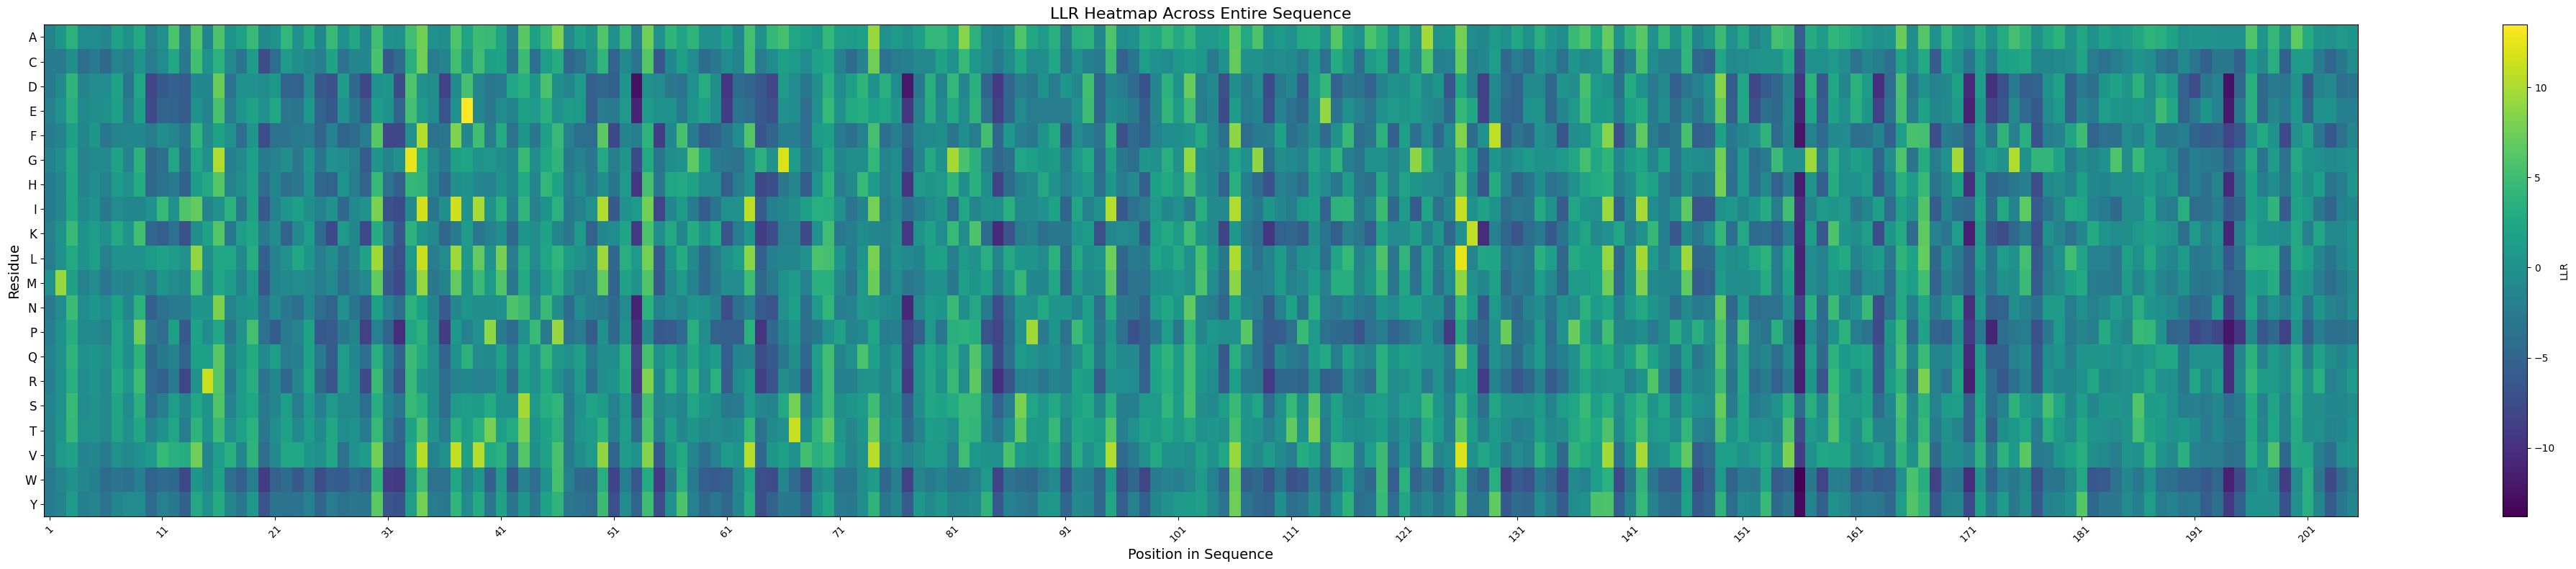

In [22]:
import torch
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForMaskedLM

def compute_llrs_at_position(model, tokenizer, sequence, position, device):
    """
    Computes the log-likelihood ratios (LLRs) for all possible amino acid substitutions
    at a given position and returns a DataFrame.
    
    Args:
        model: The masked language model.
        tokenizer: The corresponding tokenizer.
        sequence: Protein sequence (string).
        position: The position to analyze (1-indexed).
        device: torch.device to run the model.
    
    Returns:
        A pandas DataFrame with columns:
          - 'Residue': candidate amino acid,
          - 'Token_ID': the candidate token id,
          - 'Token_Str': the decoded token string,
          - 'Log_Prob': log probability for candidate at masked position,
          - 'LLR': log(prob(candidate)) - log(prob(wild_type)).
    """
    # List of 20 standard amino acids.
    amino_acids = list("ACDEFGHIKLMNPQRSTVWY")
    
    # Adjust position from 1-indexed to 0-indexed.
    idx = position - 1
    wild_type = sequence[idx]
    
    # Tokenize the full sequence (assumes one token per residue).
    encoded = tokenizer(sequence, return_tensors="pt")
    input_ids = encoded.input_ids.to(device)
    attention_mask = encoded.attention_mask.to(device)
    
    # Create a copy and mask the target position.
    masked_input_ids = input_ids.clone()
    mask_token_id = tokenizer.mask_token_id
    if mask_token_id is None:
        raise ValueError("The tokenizer does not have a mask token!")
    masked_input_ids[0, idx] = mask_token_id
    
    # Forward pass through the model.
    model.to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(masked_input_ids, attention_mask=attention_mask)
        logits = outputs.logits  # shape: [batch, seq_length, vocab_size]
    
    # Get logits at the masked position and convert to probabilities.
    position_logits = logits[0, idx]
    probs = torch.nn.functional.softmax(position_logits, dim=-1)
    eps = 1e-10  # small epsilon to avoid log(0)
    
    # Get wild-type probability and its log probability.
    wt_token_id = tokenizer.convert_tokens_to_ids(wild_type)
    if wt_token_id is None:
        raise ValueError(f"Wildtype residue '{wild_type}' could not be converted to a token ID.")
    prob_wt = probs[wt_token_id].item()
    log_prob_wt = math.log(prob_wt + eps)
    
    results = []
    for aa in amino_acids:
        aa_token_id = tokenizer.convert_tokens_to_ids(aa)
        if aa_token_id is None:
            continue
        
        # Get the token string from the token id.
        token_str = tokenizer.decode([aa_token_id]).strip()
        prob_aa = probs[aa_token_id].item()
        log_prob_aa = math.log(prob_aa + eps)
        llr = log_prob_aa - log_prob_wt
        results.append({
            "Residue": aa,
            "Token_ID": aa_token_id,
            "Token_Str": token_str,
            "Log_Prob": log_prob_aa,
            "LLR": llr
        })
    
    df = pd.DataFrame(results)
    return df

def compute_llr_matrix(model, tokenizer, sequence, device):
    """
    Computes the LLR for all 20 amino acids at every position in the sequence.
    
    Args:
        model: The masked language model.
        tokenizer: The corresponding tokenizer.
        sequence: The protein sequence (string).
        device: torch.device to run the model.
    
    Returns:
        A numpy array of shape (20, L) containing the LLR values,
        and a list of positions (1-indexed) corresponding to the columns.
        The rows correspond to the 20 standard amino acids in the order "ACDEFGHIKLMNPQRSTVWY".
    """
    amino_acids = list("ACDEFGHIKLMNPQRSTVWY")
    n_positions = len(sequence)
    llr_matrix = np.zeros((len(amino_acids), n_positions))
    
    # Loop over every position in the sequence.
    for pos in range(1, n_positions + 1):
        df_llrs = compute_llrs_at_position(model, tokenizer, sequence, position=pos, device=device)
        # Reorder rows to match the fixed order of amino_acids.
        df_llrs = df_llrs.set_index("Residue").loc[amino_acids]
        llr_matrix[:, pos - 1] = df_llrs["LLR"].values
        
    return llr_matrix, list(range(1, n_positions + 1))

def plot_llr_heatmap(llr_matrix, sequence, save_path=None):
    """
    Plots a heatmap of LLR values across the entire sequence and optionally saves the figure.
    
    Args:
        llr_matrix: A (20 x L) numpy array where L is the sequence length.
        sequence: The protein sequence (string). Used to annotate the x-axis.
        save_path: File path to save the figure (e.g. "llr_heatmap.png"). If None, the figure isn't saved.
    """
    amino_acids = list("ACDEFGHIKLMNPQRSTVWY")
    n_positions = len(sequence)
    
    fig, ax = plt.subplots(figsize=(max(10, n_positions/5), 8))
    cax = ax.imshow(llr_matrix, cmap='viridis', aspect='auto')
    
    # Set y-axis ticks: one for each amino acid.
    ax.set_yticks(np.arange(len(amino_acids)))
    ax.set_yticklabels(amino_acids, fontsize=12)
    
    # Set x-axis ticks (display a subset if the sequence is long)
    pos_ticks = np.arange(0, n_positions, max(1, n_positions // 20))
    ax.set_xticks(pos_ticks)
    ax.set_xticklabels([str(p) for p in (np.array(pos_ticks) + 1)], rotation=45, fontsize=10)
    
    ax.set_xlabel("Position in Sequence", fontsize=14)
    ax.set_ylabel("Residue", fontsize=14)
    ax.set_title("LLR Heatmap Across Entire Sequence", fontsize=16)
    fig.colorbar(cax, ax=ax, label="LLR")
    plt.tight_layout()
    
    if save_path is not None:
        plt.savefig(save_path)
        print(f"Heatmap figure saved to {save_path}")
    
    plt.show()

# Example usage:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
protein_sequence = (
    'MQWQTKLPLIAILRGITPDEALAHVGAVIDAGFDAVEIPLNSPQWEQSIPAIVDAYGDKA'
    'LIGAGTVLKPEQVDALARMGCQLIVTPNIHSEVIRRAVGYGMTVCPGCATATEAFTALEA'
    'GAQALKIFPSSAFGPQYIKALKAVLPSDIAVFAVGGVTPENLAQWIDAGCAGAGLGSDLY'
    'RAGQSVERTAQQAAAFVKAYREAVQ'
)


# Example configuration
base_model_name = "facebook/esm2_t30_150M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
# Load your model; here we use the pretrained model as an example.
model = AutoModelForMaskedLM.from_pretrained(base_model_name)
    
# Compute the full LLR matrix across the sequence.
llr_matrix, positions = compute_llr_matrix(model, tokenizer, protein_sequence, device)

# Create a DataFrame for the heatmap values.
amino_acids = list("ACDEFGHIKLMNPQRSTVWY")
df_heatmap = pd.DataFrame(llr_matrix, index=amino_acids, columns=positions)

# Save the heatmap values to a CSV file.
csv_filename = "pretrained_dgoa_llr_heatmap.csv"
df_heatmap.to_csv(csv_filename)
print(f"LLR heatmap values saved to {csv_filename}")

# Plot the heatmap and save the figure.
figure_filename = "pretrained_dgoa_llr_heatmap.png"
plot_llr_heatmap(llr_matrix, protein_sequence, save_path=figure_filename)


LLR heatmap values saved to finetuned_dgoa_llr_heatmap.csv
Heatmap figure saved to finetuned_dgoa_llr_heatmap.png


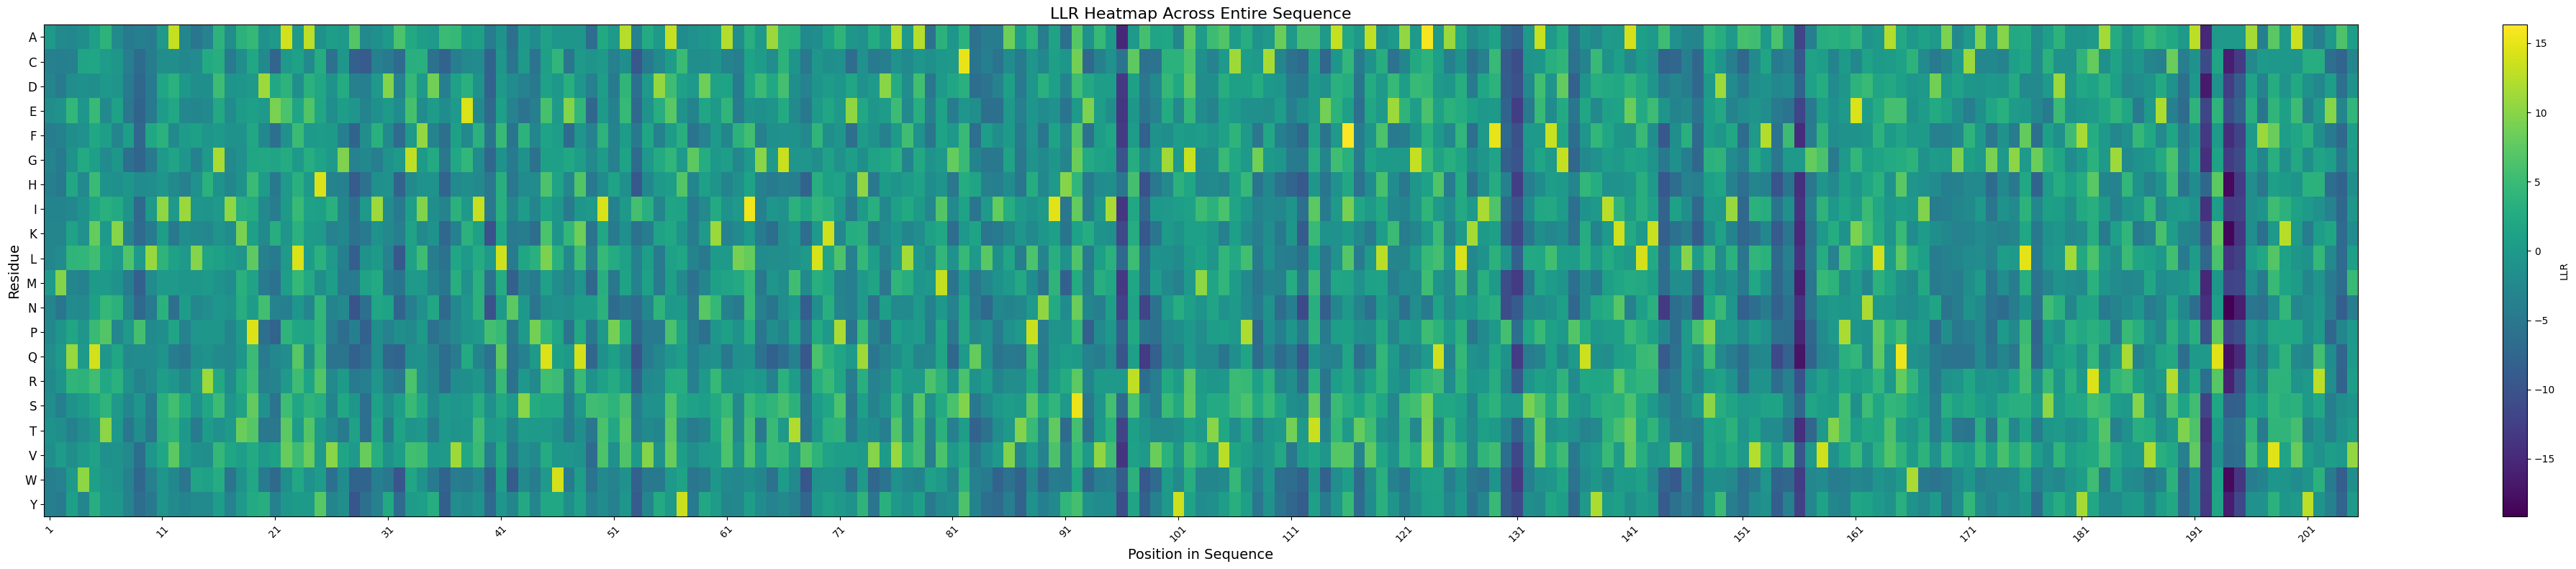

In [23]:
# Compute the full LLR matrix across the sequence.
llr_matrix, positions = compute_llr_matrix(model_finetuned, tokenizer, protein_sequence, device)

# Create a DataFrame for the heatmap values.
amino_acids = list("ACDEFGHIKLMNPQRSTVWY")
df_heatmap = pd.DataFrame(llr_matrix, index=amino_acids, columns=positions)

# Save the heatmap values to a CSV file.
csv_filename = "finetuned_dgoa_llr_heatmap.csv"
df_heatmap.to_csv(csv_filename)
print(f"LLR heatmap values saved to {csv_filename}")

# Plot the heatmap and save the figure.
figure_filename = "finetuned_dgoa_llr_heatmap.png"
plot_llr_heatmap(llr_matrix, protein_sequence, save_path=figure_filename)

In [25]:
import pandas as pd

# List of mutations as strings.
mutations = ['F33I', 'D58N', 'A75V', 'Q72H', 'V85A', 'V154F', 'Y180F']

def parse_mutation(mutation_str):
    """
    Parses a mutation string such as "F33I" into:
      - wt: the wild-type residue (for reference)
      - pos: the position (1-indexed)
      - mut: the mutant residue.
    """
    wt = mutation_str[0]      # For example, 'F'
    mutant = mutation_str[-1]  # For example, 'I'
    pos = int(mutation_str[1:-1])
    return wt, pos, mutant

# Load CSV files.
pretrained_csv = "pretrained_dgoa_llr_heatmap.csv"
finetuned_csv = "finetuned_dgoa_llr_heatmap.csv"

# Read CSV with the first column as the index (the amino acid letters)
pretrained_df = pd.read_csv(pretrained_csv, index_col=0)
finetuned_df = pd.read_csv(finetuned_csv, index_col=0)

# Ensure column headers (positions) are strings.
pretrained_df.columns = pretrained_df.columns.astype(str)
finetuned_df.columns = finetuned_df.columns.astype(str)

print("LLR values and delta for each mutation:\n")

for mutation in mutations:
    wt, pos, mut = parse_mutation(mutation)
    pos_str = str(pos)
    
    try:
        # Look up LLR values for the mutant residue at the given position.
        pretrained_llr = pretrained_df.loc[mut, pos_str]
        finetuned_llr = finetuned_df.loc[mut, pos_str]
    except KeyError as e:
        print(f"Error: Could not find data for mutation {mutation}: {e}")
        continue
        
    # Compute the delta: finetuned LLR minus pretrained LLR.
    delta = finetuned_llr - pretrained_llr
        
    # Print the results.
    print(f"Mutation {mutation}:")
    print(f"  Pretrained LLR: {pretrained_llr}")
    print(f"  Finetuned LLR:  {finetuned_llr}")
    print(f"  Delta (Finetuned - Pretrained): {delta}\n")


LLR values and delta for each mutation:

Mutation F33I:
  Pretrained LLR: -0.8771993507874214
  Finetuned LLR:  0.7108764118792212
  Delta (Finetuned - Pretrained): 1.5880757626666426

Mutation D58N:
  Pretrained LLR: 0.5295904925206525
  Finetuned LLR:  -5.022577894607164
  Delta (Finetuned - Pretrained): -5.552168387127817

Mutation A75V:
  Pretrained LLR: -1.6569427988250005
  Finetuned LLR:  0.11064792278089
  Delta (Finetuned - Pretrained): 1.7675907216058906

Mutation Q72H:
  Pretrained LLR: -0.977611540650345
  Finetuned LLR:  -2.5891506802548605
  Delta (Finetuned - Pretrained): -1.6115391396045156

Mutation V85A:
  Pretrained LLR: -1.3141011965399434
  Finetuned LLR:  -4.06480672041882
  Delta (Finetuned - Pretrained): -2.7507055238788762

Mutation V154F:
  Pretrained LLR: -4.262235006064337
  Finetuned LLR:  -5.611050426548172
  Delta (Finetuned - Pretrained): -1.3488154204838354

Mutation Y180F:
  Pretrained LLR: 2.0863721905798416
  Finetuned LLR:  5.2091241976685545
  Delt